<a href="https://colab.research.google.com/github/Azmouc1k/azmo-portfolio/blob/main/EEG_Sleep_Stage_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.4 MB/s eta 0:00:00


In [ ]:
pip install --upgrade mne


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Classification label target
EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# Frequency bands range in Hz for EEG
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

# Number of participants used in the analysis
NUM_PARTICIPANT = 10






import mne
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, LeaveOneOut
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from mne.datasets.sleep_physionet.age import fetch_data

# Set MNE verbosity level to WARNING or ERROR
mne.set_log_level("error")


def load_data(participant_id, event_id=EVENT_ID):
    """
    Load EEG data and create 30-second epochs for a given participant.

    Parameters
    ----------
    participant_id : int
        ID of the participant to load data for.

    event_id : dict
        Mapping of sleep stages to numerical IDs.

    Returns
    -------
    raw_edf : mne.io.Raw
        The raw EEG signal with annotations.

    events : ndarray
        Array of events derived from annotations.

    epochs : mne.Epochs
        Epochs object containing 30-second EEG data segments.
    """

    ANNOTATION_EVENT_ID = {
        "Sleep stage W": 1,
        "Sleep stage 1": 2,
        "Sleep stage 2": 3,
        "Sleep stage 3": 4,
        "Sleep stage 4": 4,
        "Sleep stage R": 5,
    }

    # Fetch data for the participant
    [participant_file] = fetch_data(subjects=[participant_id], recording=[1])

    # Load EEG signal
    raw_edf = mne.io.read_raw_edf(
        participant_file[0],
        stim_channel="Event marker",
        infer_types=True,
        preload=True,
        verbose="error"
    )

    # Load annotations
    annotation_edf = mne.read_annotations(participant_file[1])

    # Keep wake events 30 minutes before and after sleep
    annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 60, annotation_edf[-2]["onset"] + 30 * 60)

    # Attach annotations to the raw EEG data
    raw_edf.set_annotations(annotation_edf, emit_warning=False)

    # Chunk the data into 30-second epochs
    events, _ = mne.events_from_annotations(
        raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0, verbose="error"
    )

    # Define epochs
    tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]
    epochs = mne.Epochs(
        raw=raw_edf,
        events=events,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
        verbose="error",
    )

    return raw_edf, events, epochs


In [ ]:
# Load data for all participants
all_participant_epochs = []
for participant_id in range(NUM_PARTICIPANT):
    try:
        _, _, epochs = load_data(participant_id=participant_id)
        all_participant_epochs.append(epochs)
        print(f"Loaded data for participant {participant_id}")
    except Exception as e:
        print(f"Error loading data for participant {participant_id}: {e}")


Loaded data for participant 0


Loaded data for participant 1


Loaded data for participant 2


Loaded data for participant 3


Loaded data for participant 4


Loaded data for participant 5


Loaded data for participant 6


Loaded data for participant 7


Loaded data for participant 8


Loaded data for participant 9


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM (Pure)...
Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.3057 - loss: 1.7689 - val_accuracy: 0.5291 - val_loss: 1.2190
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.5467 - loss: 1.1476 - val_accuracy: 0.6027 - val_loss: 1.0597
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6065 - loss: 1.0528 - val_accuracy: 0.6424 - val_loss: 0.9700
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.6077 - loss: 1.0380 - val_accuracy: 0.6531 - val_loss: 0.9242
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6255 - loss: 0.9787 - val_accuracy: 0.6066 - val_loss: 1.0462
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6102 - loss: 1.0152 - val_accuracy: 0.6705 - val_loss: 0.8664
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6458 - loss: 0.9383 - val_accuracy: 0.6453 - val_loss: 0.9048
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - a

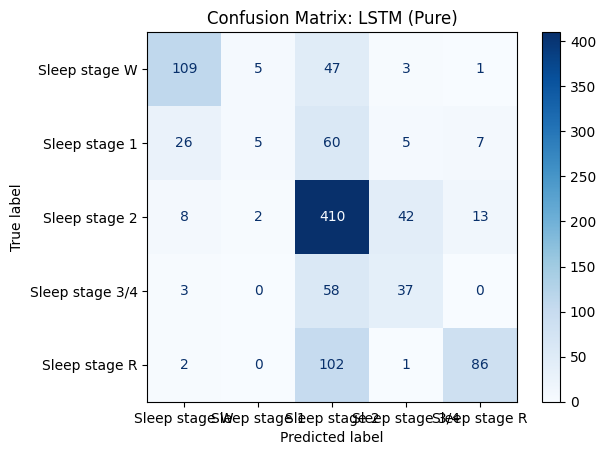

                 precision    recall  f1-score   support

  Sleep stage W       0.74      0.66      0.70       165
  Sleep stage 1       0.42      0.05      0.09       103
  Sleep stage 2       0.61      0.86      0.71       475
Sleep stage 3/4       0.42      0.38      0.40        98
  Sleep stage R       0.80      0.45      0.58       191

       accuracy                           0.63      1032
      macro avg       0.60      0.48      0.49      1032
   weighted avg       0.63      0.63      0.59      1032

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step

LSTM with Temporal Context Accuracy: 0.66


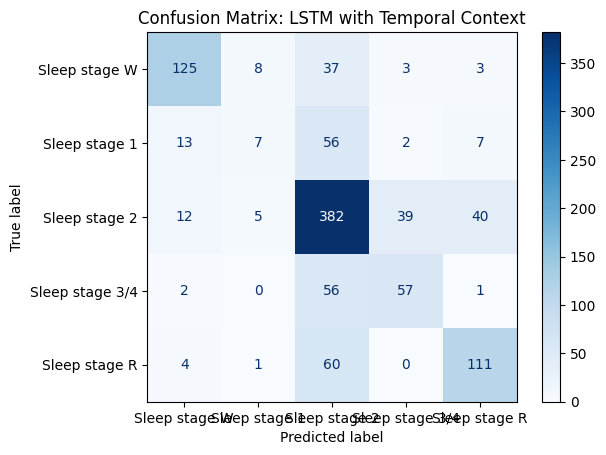

                 precision    recall  f1-score   support

  Sleep stage W       0.80      0.71      0.75       176
  Sleep stage 1       0.33      0.08      0.13        85
  Sleep stage 2       0.65      0.80      0.71       478
Sleep stage 3/4       0.56      0.49      0.53       116
  Sleep stage R       0.69      0.63      0.66       176

       accuracy                           0.66      1031
      macro avg       0.61      0.54      0.56      1031
   weighted avg       0.64      0.66      0.64      1031



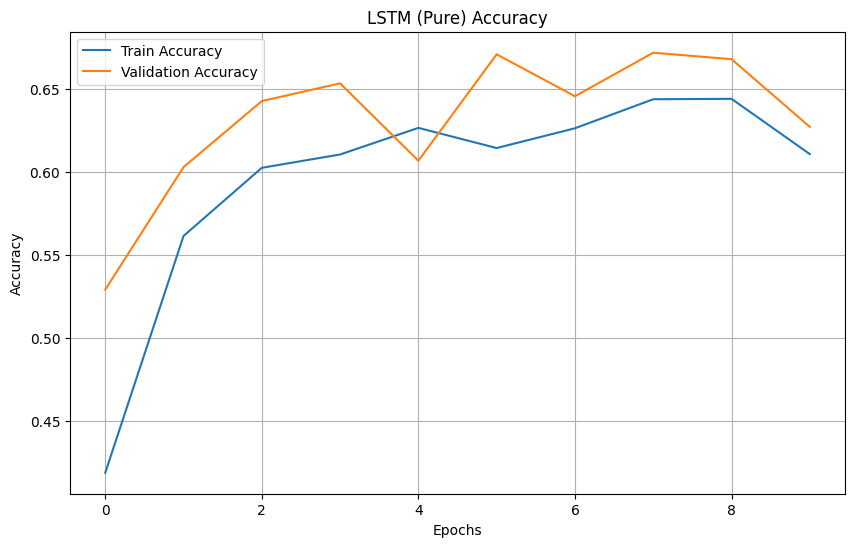

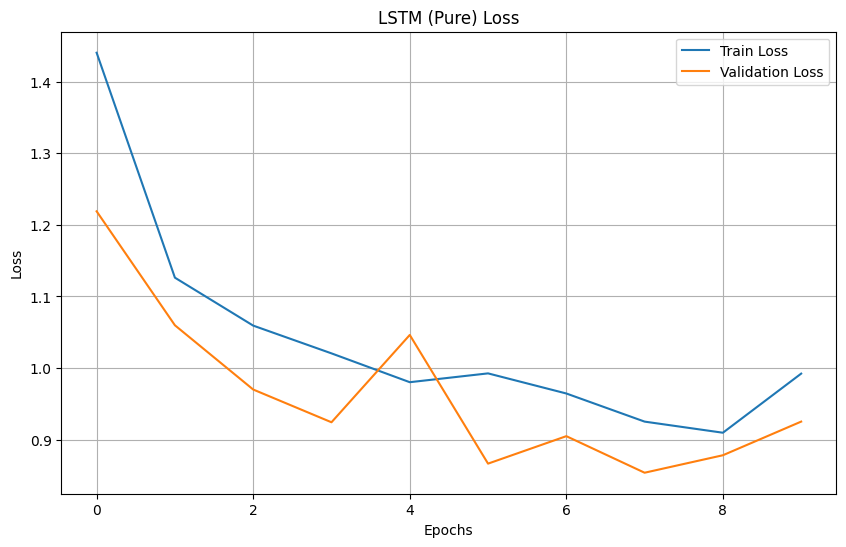

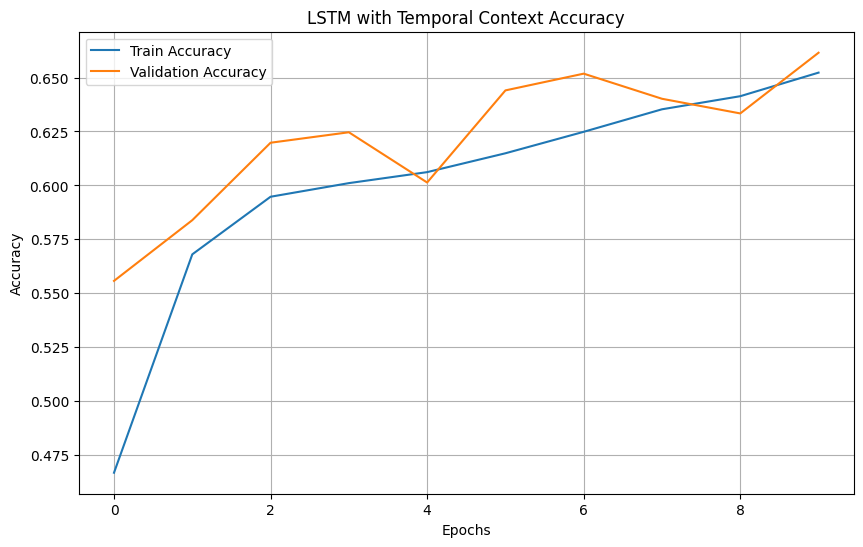

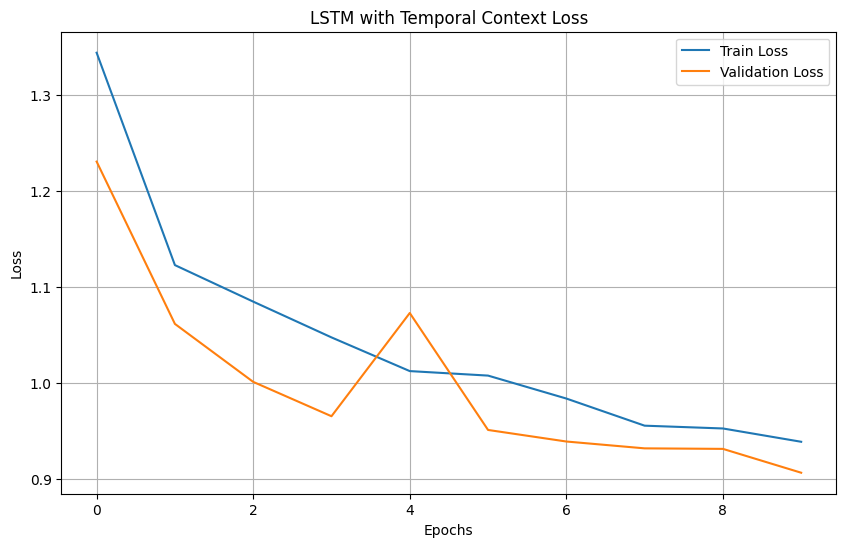

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Preprocess Data for LSTM
def preprocess_epochs(all_participant_epochs):
    """
    Convert MNE epochs to NumPy arrays and prepare sequences for LSTM.
    """
    data = []
    labels = []
    for epochs in all_participant_epochs:
        # Get data and labels
        data_array = epochs.get_data()  # shape: (n_epochs, n_channels, n_timepoints)
        labels_array = epochs.events[:, -1]  # labels corresponding to epochs

        # Reshape data for LSTM: (samples, time_steps, features)
        data_array = np.transpose(data_array, (0, 2, 1))  # shape: (n_epochs, n_timepoints, n_channels)
        data.extend(data_array)
        labels.extend(labels_array)

    return np.array(data), np.array(labels)

# Step 2: Add Temporal Context
def add_temporal_context(X, y, window_size=2):

    X_tc = []
    y_tc = []
    num_samples = len(X)

    for i in range(num_samples):
        if i >= window_size and i + window_size < num_samples:
            context = X[i - window_size:i + window_size + 1]  # Take surrounding epochs
            X_tc.append(context)
            y_tc.append(y[i])  # Use the central epoch's label

    X_tc = np.array(X_tc)  # Shape: (samples, temporal_window, time_steps, features)
    y_tc = np.array(y_tc)
    return X_tc, y_tc

# Step 3: Load and Preprocess Data
NUM_PARTICIPANT = 5
all_participant_epochs = []
for participant_id in range(NUM_PARTICIPANT):
    _, _, epochs = load_data(participant_id=participant_id)
    all_participant_epochs.append(epochs)

# Preprocess Data
X, y = preprocess_epochs(all_participant_epochs)

# Normalize Data
scaler = StandardScaler()
X_shape = X.shape
X = X.reshape(-1, X_shape[-1])  # Flatten channels for normalization
X = scaler.fit_transform(X).reshape(X_shape)

# Convert labels to categorical
num_classes = len(np.unique(y))
y_categorical = tf.keras.utils.to_categorical(y - 1, num_classes)  # Convert labels to 0-indexed

# Step 4: Train-Test Split for LSTM (Pure)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Step 5: Train-Test Split for LSTM + TC
window_size = 2
X_tc, y_tc = add_temporal_context(X, y, window_size=window_size)
y_tc_categorical = tf.keras.utils.to_categorical(y_tc - 1, num_classes)  # Convert labels to categorical
X_train_tc, X_test_tc, y_train_tc, y_test_tc = train_test_split(X_tc, y_tc_categorical, test_size=0.2, random_state=42)

# Step 6: Build LSTM Model
def build_lstm_model(input_shape, num_classes):
    """
    Build an LSTM model for EEG classification.
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 7: Train LSTM (Pure)
lstm_model = build_lstm_model(input_shape=X_train.shape[1:], num_classes=num_classes)
print("\nTraining LSTM (Pure)...")
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 8: Train LSTM + TC
# Adjust input shape for TC: (samples, time_steps, features)
X_train_tc_reshaped = X_train_tc.reshape(X_train_tc.shape[0], -1, X_train_tc.shape[-1])
X_test_tc_reshaped = X_test_tc.reshape(X_test_tc.shape[0], -1, X_test_tc.shape[-1])

lstm_tc_model = build_lstm_model(input_shape=X_train_tc_reshaped.shape[1:], num_classes=num_classes)
print("\nTraining LSTM with Temporal Context...")
history_lstm_tc = lstm_tc_model.fit(X_train_tc_reshaped, y_train_tc, validation_data=(X_test_tc_reshaped, y_test_tc), epochs=10, batch_size=32)

# Step 9: Evaluate Models
def evaluate_model(model, X_test, y_test, title):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    acc = np.mean(y_pred == y_true)
    print(f"\n{title} Accuracy: {acc:.2f}")
    conf_matrix = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=list(EVENT_ID.keys())).plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {title}")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=list(EVENT_ID.keys())))

# Evaluate LSTM (Pure)
evaluate_model(lstm_model, X_test, y_test, "LSTM (Pure)")

# Evaluate LSTM + TC
evaluate_model(lstm_tc_model, X_test_tc_reshaped, y_test_tc, "LSTM with Temporal Context")

# Step 10: Plot Training and Validation Curves
def plot_training_curves(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot Training Curves
plot_training_curves(history_lstm, "LSTM (Pure)")
plot_training_curves(history_lstm_tc, "LSTM with Temporal Context")


### tune


In [ ]:
def build_lstm_model(input_shape, num_classes, lstm_units=64, dense_units=32, dropout_rate=0.3):
    """
    Build an LSTM model for EEG classification with customizable hyperparameters.
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



Running configuration 1/4: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'epochs': 10}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Accuracy for Run 1: 0.68


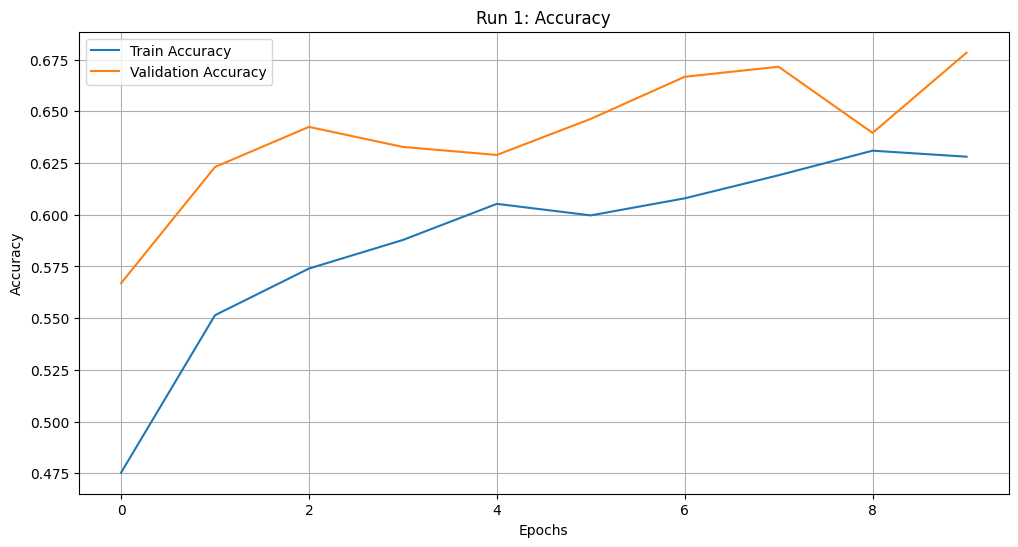

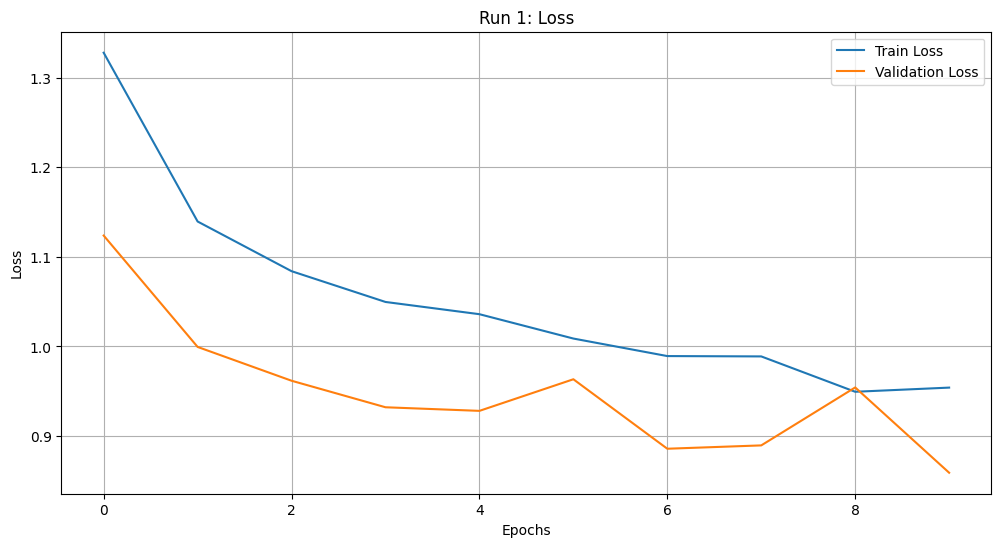


Running configuration 2/4: {'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 10}
Test Accuracy for Run 2: 0.53


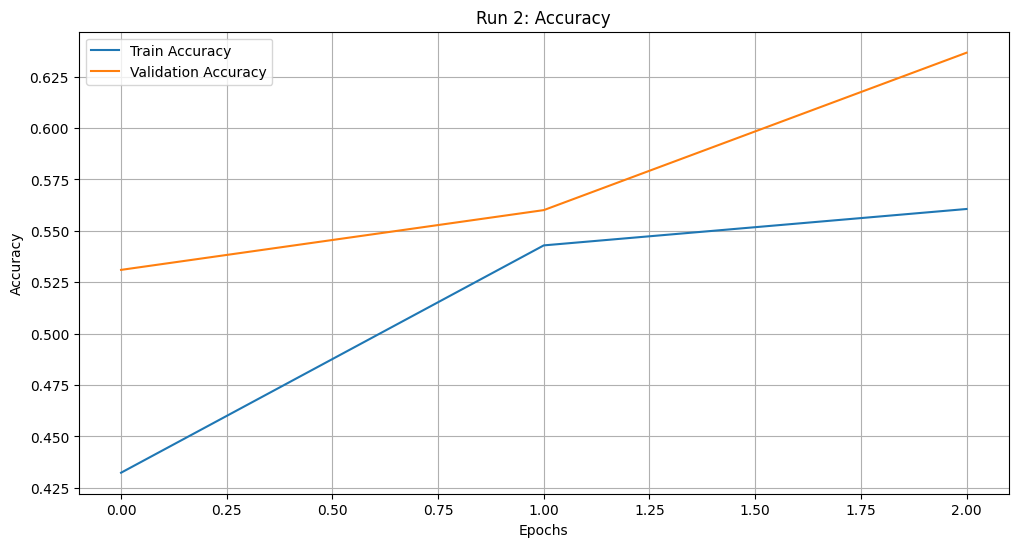

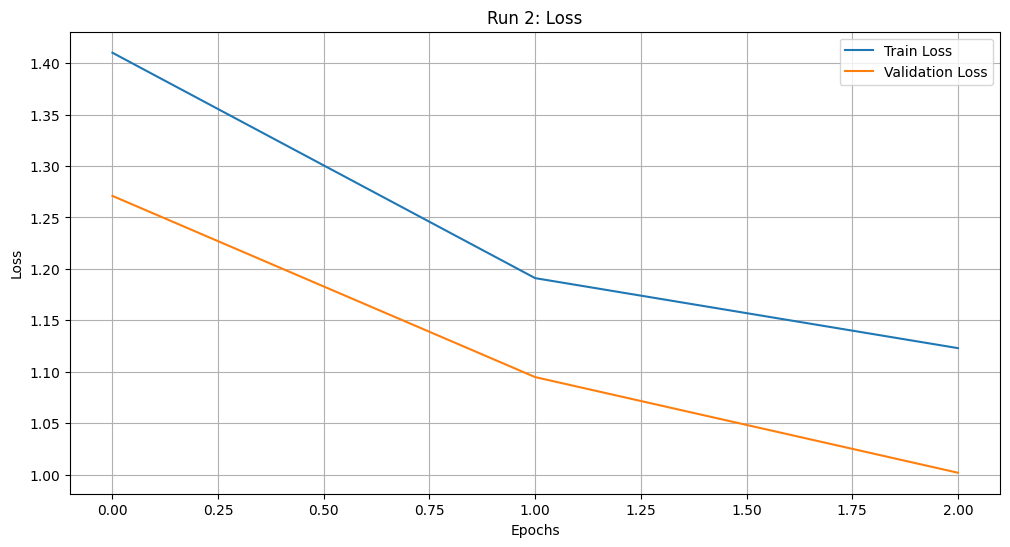


Running configuration 3/4: {'lstm_units': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'epochs': 10}
Test Accuracy for Run 3: 0.60


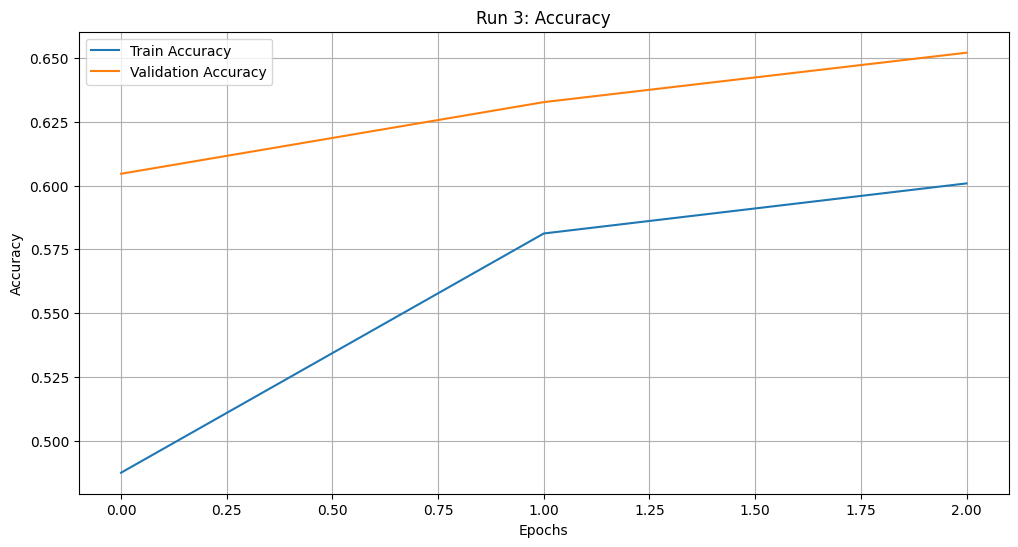

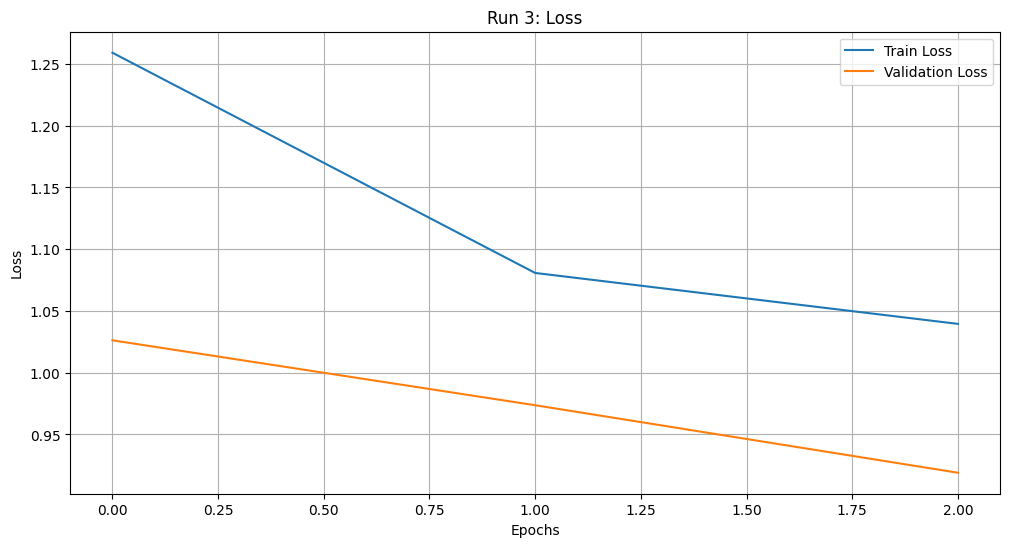


Running configuration 4/4: {'lstm_units': 64, 'dense_units': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 10}
Test Accuracy for Run 4: 0.54


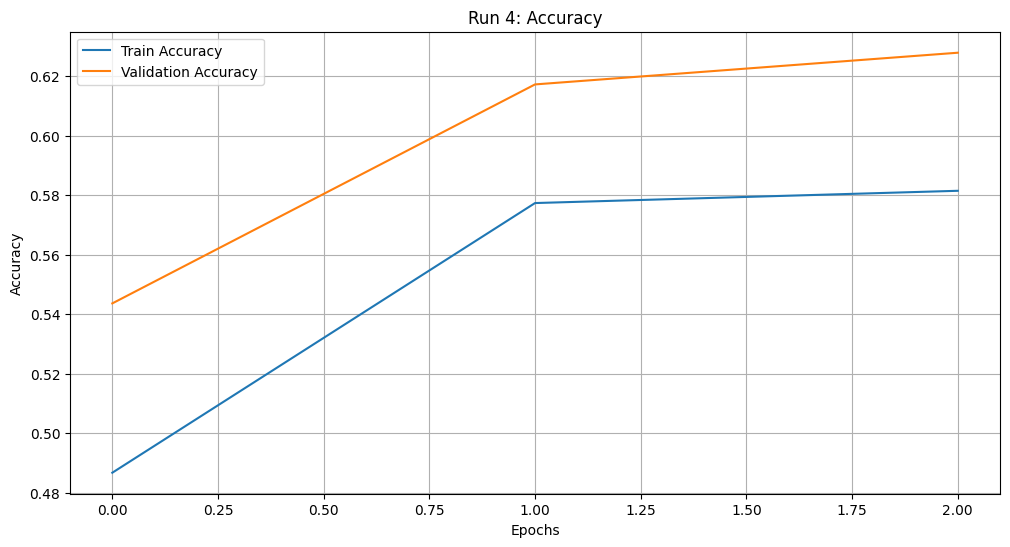

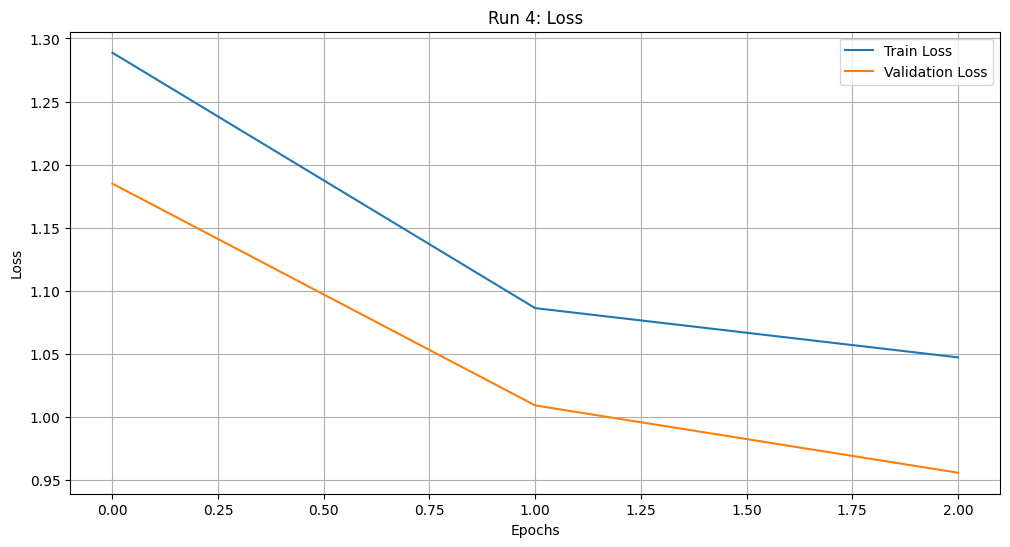


Best Hyperparameters:
{'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'epochs': 10}
Best Test Accuracy: 0.68


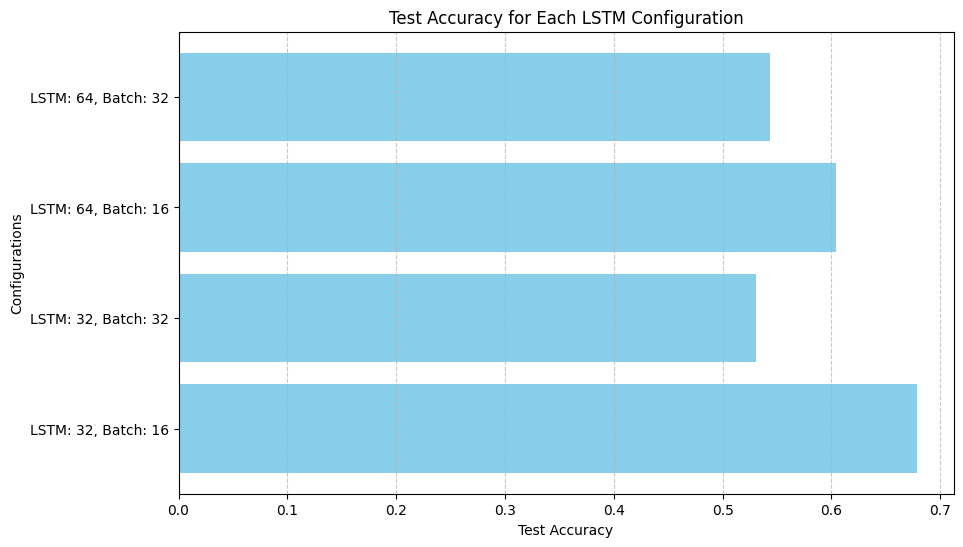

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


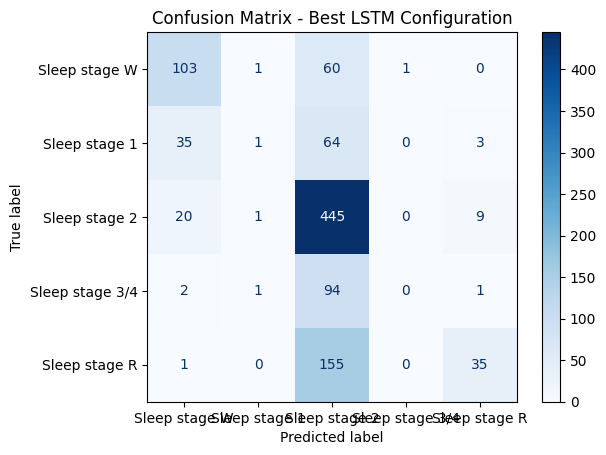

                 precision    recall  f1-score   support

  Sleep stage W       0.64      0.62      0.63       165
  Sleep stage 1       0.25      0.01      0.02       103
  Sleep stage 2       0.54      0.94      0.69       475
Sleep stage 3/4       0.00      0.00      0.00        98
  Sleep stage R       0.73      0.18      0.29       191

       accuracy                           0.57      1032
      macro avg       0.43      0.35      0.33      1032
   weighted avg       0.51      0.57      0.47      1032



In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

# Parameter grid
param_grid = {
    'lstm_units': [32, 64],  # Number of LSTM units
    'dense_units': [32],     # Number of units in dense layers
    'dropout_rate': [0.3],   # Dropout rate
    'batch_size': [16, 32],  # Batch size
    'epochs': [10]           # Number of epochs
}

# Generate parameter combinations
runs = [
    {'lstm_units': lstm_units, 'dense_units': dense_units,
     'dropout_rate': dropout_rate, 'batch_size': batch_size, 'epochs': epochs}
    for lstm_units in param_grid['lstm_units']
    for dense_units in param_grid['dense_units']
    for dropout_rate in param_grid['dropout_rate']
    for batch_size in param_grid['batch_size']
    for epochs in param_grid['epochs']
]

# To store results
results = []

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

for i, params in enumerate(runs, start=1):
    print(f"\nRunning configuration {i}/{len(runs)}: {params}")

    # Build model
    model = build_lstm_model(
        input_shape=X_train.shape[1:],
        num_classes=num_classes,
        lstm_units=params['lstm_units'],
        dense_units=params['dense_units'],
        dropout_rate=params['dropout_rate']
    )

    # Time training
    start_time = time.time()

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        callbacks=[early_stopping],
        verbose=0
    )

    end_time = time.time()

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy for Run {i}: {test_accuracy:.2f}")

    # Save results
    results.append({
        'params': params,
        'accuracy': test_accuracy,
        'history': history.history,
        'time': end_time - start_time
    })

    # Visualize training/validation curves immediately
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Run {i}: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Run {i}: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# After all runs, display the best configuration
best_run = max(results, key=lambda x: x['accuracy'])
print("\nBest Hyperparameters:")
print(best_run['params'])
print(f"Best Test Accuracy: {best_run['accuracy']:.2f}")

# Visualize Test Accuracies Across Runs
configs = [f"LSTM: {r['params']['lstm_units']}, Batch: {r['params']['batch_size']}" for r in results]
accuracies = [r['accuracy'] for r in results]

plt.figure(figsize=(10, 6))
plt.barh(configs, accuracies, color='skyblue')
plt.xlabel('Test Accuracy')
plt.ylabel('Configurations')
plt.title('Test Accuracy for Each LSTM Configuration')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Best Model Confusion Matrix
best_model_params = best_run['params']
best_model = build_lstm_model(
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    lstm_units=best_model_params['lstm_units'],
    dense_units=best_model_params['dense_units'],
    dropout_rate=best_model_params['dropout_rate']
)

# Re-train best model with early stopping (optional)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=best_model_params['epochs'],
    batch_size=best_model_params['batch_size'],
    callbacks=[early_stopping],
    verbose=0
)

# Predict and compute confusion matrix
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(EVENT_ID.keys())).plot(cmap='Blues')
plt.title('Confusion Matrix - Best LSTM Configuration')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(EVENT_ID.keys())))


In [ ]:
# 3. Class-wise Metrics for TC
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_tc, average=None)
classes = ['W', '1', '2', '3/4', 'R']

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1-Score')

plt.xticks(x, classes)
plt.ylabel('Score')
plt.title('Class-wise Metrics for Temporal Context (TC)')
plt.legend()
plt.show()


In [ ]:
!pip install shap

In [ ]:
print(raw.ch_names)

['Fpz-Cz', 'Pz-Oz', 'horizontal', 'oro-nasal', 'submental', 'rectal', 'Event marker']


<Figure size 1200x600 with 0 Axes>

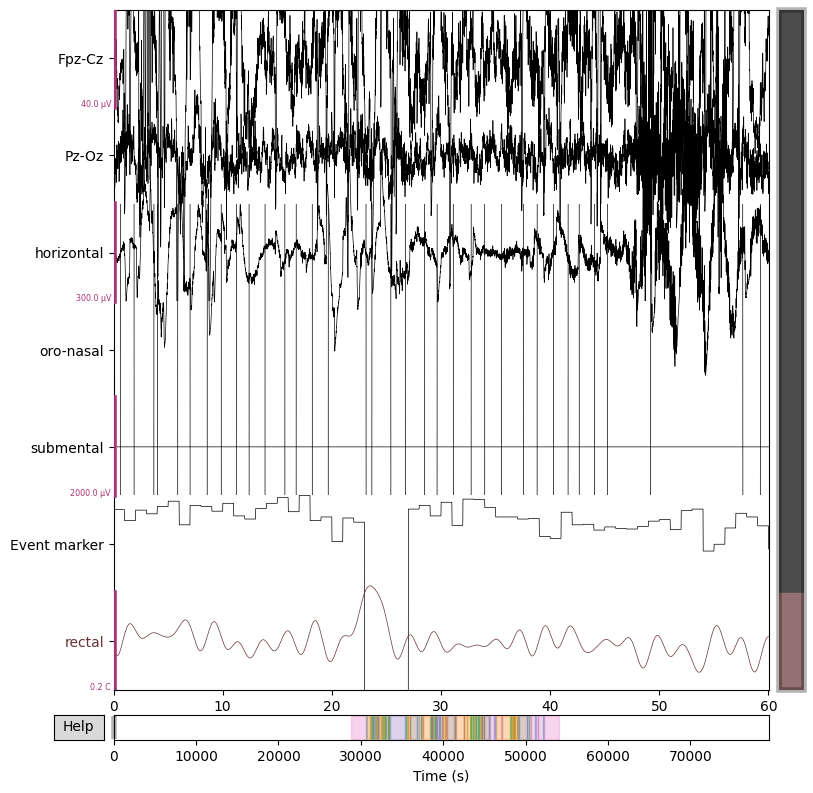

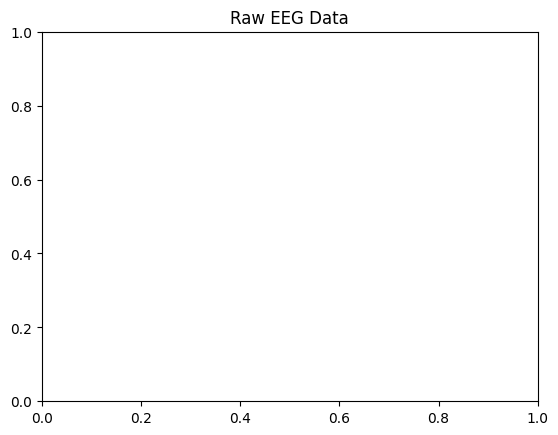

In [ ]:
import matplotlib.pyplot as plt

# Plot raw EEG signal for one participant
def plot_raw_eeg(raw, channels=['EEG Fpz-Cz', 'EEG Pz-Oz'], start=0, duration=60):
    """
    Plot raw EEG data for selected channels.

    Parameters:
    raw : mne.io.Raw
        The raw EEG data object.
    channels : list
        List of EEG channels to plot.
    start : float
        Starting time in seconds.
    duration : float
        Duration of the signal to plot in seconds.
    """
    plt.figure(figsize=(12, 6))
    raw.plot(start=start, duration=duration, picks=channels, show=True, scalings={'eeg': 20e-6})  # Use actual channel names from raw.info['ch_names']
    plt.title("Raw EEG Data")
    plt.show()

# Example usage
raw, _, _ = load_data(participant_id=0)
plot_raw_eeg(raw, channels=['Fpz-Cz', 'Pz-Oz', 'horizontal', 'oro-nasal', 'submental', 'rectal', 'Event marker'], start=0, duration=60) # Use actual channel names

<Figure size 1200x600 with 0 Axes>

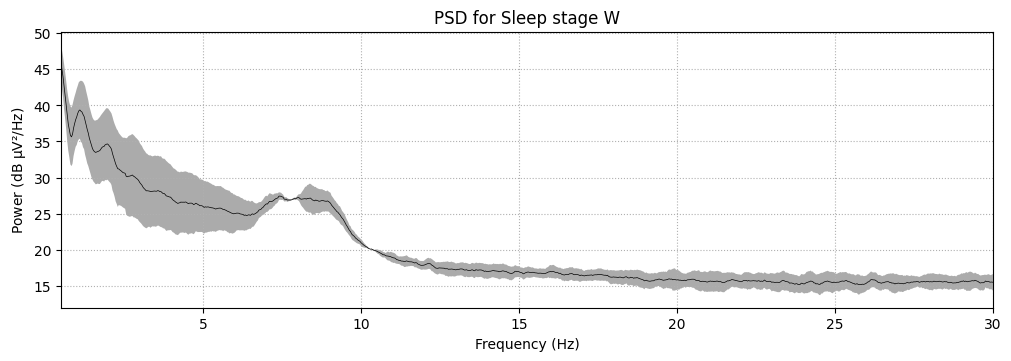

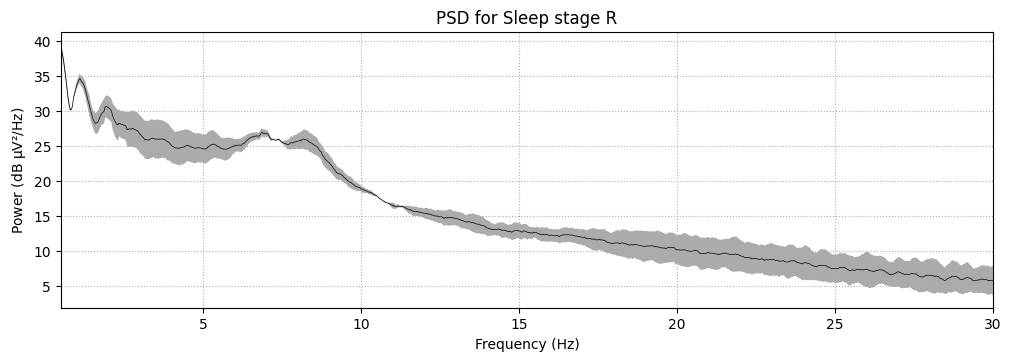

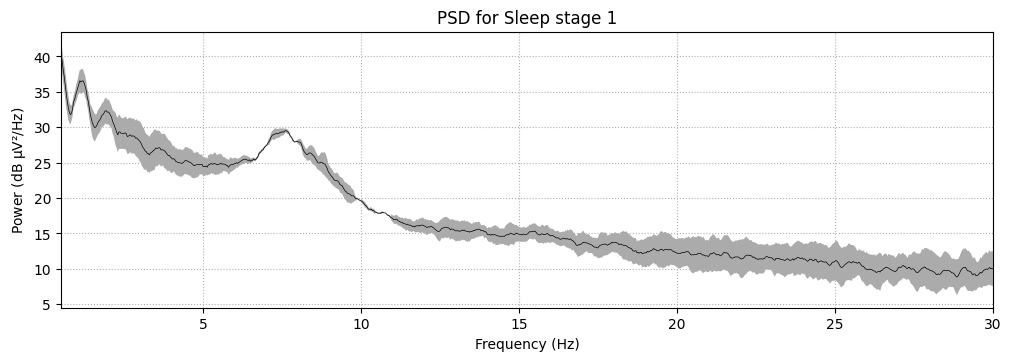

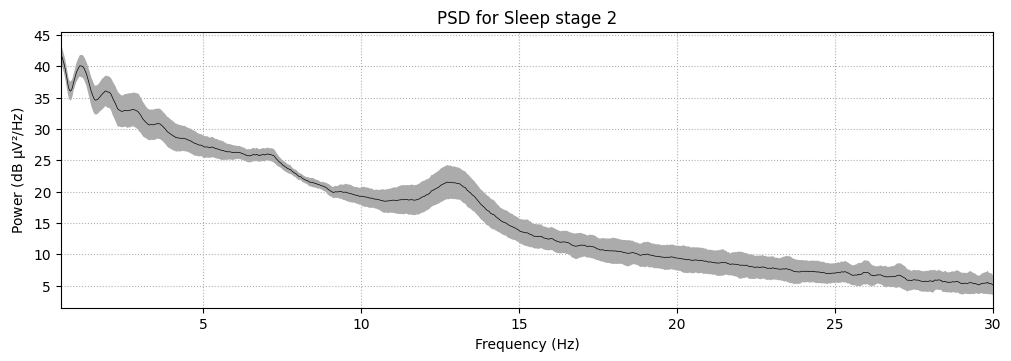

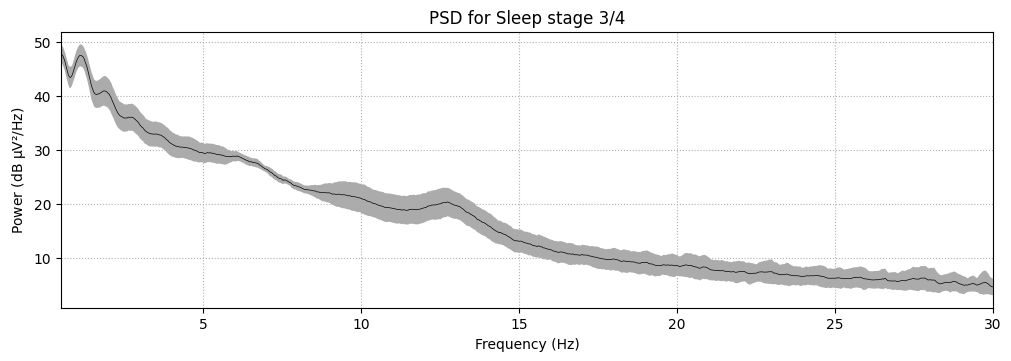

In [ ]:
def plot_psd_by_stage(epochs, sleep_stages=['Sleep stage W', 'Sleep stage R']):
    """
    Plot Power Spectral Density (PSD) for specific sleep stages.

    Parameters:
    epochs : mne.Epochs
        The EEG epochs data.
    sleep_stages : list
        List of sleep stages to plot.
    """
    plt.figure(figsize=(12, 6))
    for stage in sleep_stages:
        epochs[stage].plot_psd(fmin=0.5, fmax=30, average=True, show=False)
        plt.title(f"PSD for {stage}")
        plt.show()

# Example usage
_, _, epochs = load_data(participant_id=0)
plot_psd_by_stage(epochs, sleep_stages=['Sleep stage W', 'Sleep stage R', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3/4'])


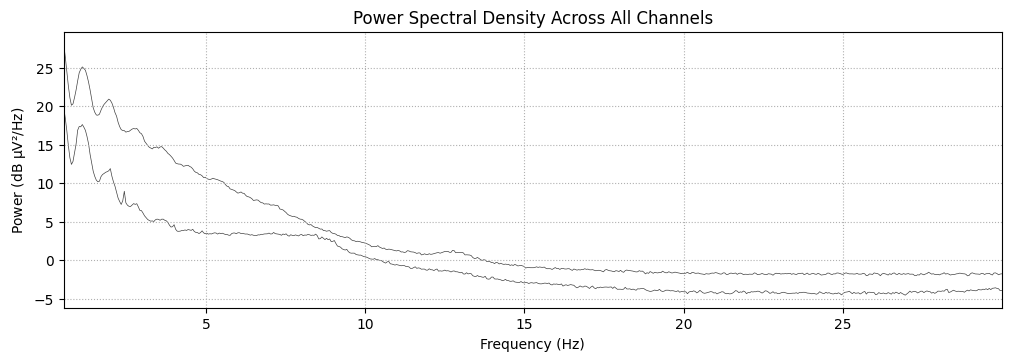

In [ ]:
def plot_psd_all_channels(raw):
    """
    Plot the Power Spectral Density (PSD) for all EEG channels.

    Parameters:
    raw : mne.io.Raw
        The raw EEG data object.
    """
    raw.plot_psd(fmin=0.5, fmax=30, average=False)
    plt.title("Power Spectral Density Across All Channels")
    plt.show()

# Plot PSD to identify active channels
plot_psd_all_channels(raw)


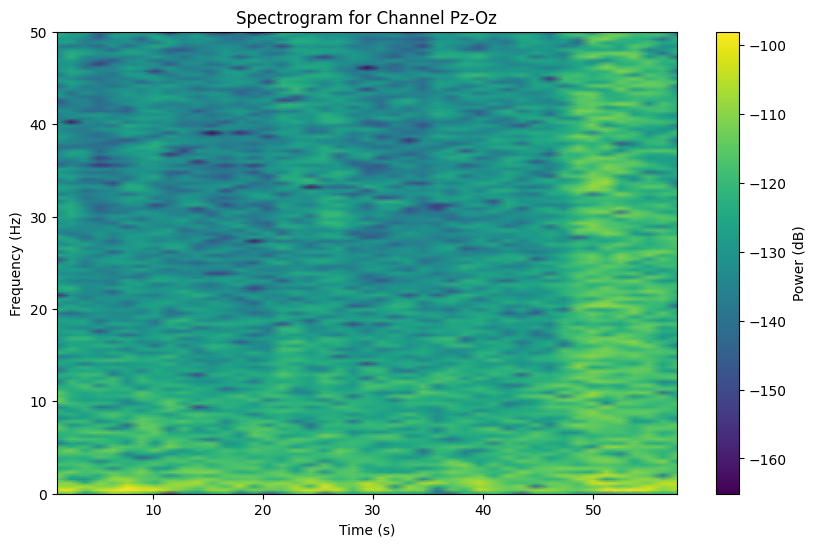

In [ ]:
import numpy as np
from scipy.signal import spectrogram

def plot_spectrogram(raw, channel='Pz-Oz', start=0, duration=60):
    """
    Plot spectrogram of EEG data for a specific channel.

    Parameters:
    raw : mne.io.Raw
        The raw EEG data.
    channel : str
        Channel to plot spectrogram for.
    start : float
        Starting time in seconds.
    duration : float
        Duration of the signal to analyze.
    """
    sfreq = raw.info['sfreq']
    start_sample = int(start * sfreq)
    end_sample = int((start + duration) * sfreq)

    # Get data for the specified channel
    data, times = raw[channel, start_sample:end_sample]
    f, t, Sxx = spectrogram(data[0], fs=sfreq, nperseg=256, noverlap=128)

    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f"Spectrogram for Channel {channel}")
    plt.show()

# Example usage
plot_spectrogram(raw, channel='Pz-Oz', start=0, duration=60)
